### Filename we're going to play with

In [1]:
#filename = "data/mturkfvppilot_scaling3_time250_2stim.csv"
filename = "data/alldata.csv"

In [2]:
stimuli_number = 9
response_type_list = c('during','after_1','after_2')
response_names = c('During', 'After stimuli (1) & response screen','After stimuli (2)')

In [3]:
trace_cutoff = 2 # mean dissimilarity for physically identical colours must be below this
antitrace_cutoff = 3.5 # mean dissimilarity accepted for maximally physically different colours must be above this
rt_cutoff = 700 # mean reaction times must be above this

In [4]:
exclude_noncompliant = FALSE

In [5]:
plotsubjects = FALSE
plot_within_between = FALSE
plotexpsummary = FALSE
across = FALSE
population = FALSE

### Initialisations

In [6]:
# live dangerously, get rid of pesky warnings
oldw <- getOption("warn")
options(warn = -1)

In [7]:
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(MASS)
library(Matrix)
library(reshape2)
library(ape) # stats
library(vegan) # stats
library(RColorBrewer)
library(cocor)
library(DescTools)
library(reshape2)
library(grid)
library(ggplotify)


Attaching package: 'tidyr'

The following object is masked _by_ '.GlobalEnv':

    population


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package: permute
Loading

In [8]:
# rainbowcloud theme for plotting, stolen from: 
# https://micahallen.org/2018/03/15/introducing-raincloud-plots/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com
raincloud_theme = theme(
text = element_text(size = 10),
axis.title.x = element_text(size = 16),
axis.title.y = element_text(size = 16),
axis.text = element_text(size = 14),
axis.text.x = element_text(angle = 45, vjust = 0.5),
legend.title=element_text(size=16),
legend.text=element_text(size=16),
legend.position = "right",
plot.title = element_text(lineheight=.8, face="bold", size = 16),
panel.border = element_blank(),
panel.grid.minor = element_blank(),
panel.grid.major = element_blank(),
axis.line.x = element_line(colour = 'black', size=0.5, linetype='solid'),
axis.line.y = element_line(colour = 'black', size=0.5, linetype='solid'))

In [9]:
# stealing ability to make flat violin plots
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")

### Functions we're going to use to do the analysis later

#### Miscellaneous

In [10]:
# get plot eccentricity labels
ploteccen <- function(datadf){
    if(datadf$Circle_1[1] == -1){
            label1 = 'Foveal'
        } else {
            label1 = 'Peripheral'
        }
        if(datadf$Circle_2[1] == -1){
            label2 = 'Foveal'
        } else {
            label2 = 'Peripheral'
        }
    return(c(label1,label2))
}

e2l <- function(eccentricity){
    if(eccentricity == -1){
        return('Foveal')
    } else {
        return('Peripheral')
    }
}

l2e <- function(eccentricity){
    if(eccentricity == 'Foveal'){
        return(-1)
    } else {
        return(1)
    }
}

#### Dissimilarity Matrices

In [11]:
# obtain dissimilarity matrices with particular eccentricity values from dataframes
dissimdata <- function(datadf, colors, eccentricity1, eccentricity2){
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datatemp = subset(datadf, Circle_1 == eccentricity1)
    datatemp = subset(datatemp, Circle_2 == eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [12]:
# plot a dissimilarity matrix
dissimplot <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = p_confidence)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [13]:
df2mat_asymmetry <- function(datadf,eccentricity1,eccentricity2){
    
    datadf <- dissimdata(datadf, colors, eccentricity1, eccentricity2)
    
    # aggregate over the remaining columns of interest
    nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    nmdsdata$Color_1 <- nmdsdata$Group.1
    nmdsdata$Color_2 <- nmdsdata$Group.2

    nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","p_confidence"))  # get rid of unnecessary columns
    nmdsmatrix <- spread(nmdsdata, Color_1, p_confidence)
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    matdf <- as.data.frame(nmdsmatrix - t(nmdsmatrix))
    matdf$colorset <- c(abcolors)
    num_colors <- length(colors)
    matdf <- matdf %>% gather(othercolor,asymmetry ,1:num_colors)
    return(matdf)
}

In [14]:
# plot an asymmetry matrix
asymmetry_plot <- function(datadf,eccentricity1,eccentricity2,colors){
    
    # labeling the types
    label1 <- "Presented"
    label2 <- "Response Screen"
    
    datadf <- df2mat_asymmetry(datadf,eccentricity1,eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datadf$colorset <- with(datadf, factor(colorset, levels = colors))
    datadf$othercolor <- with(datadf, factor(othercolor, levels = colors))
    
    plot <- ggplot(datadf, aes(x = colorset, y = othercolor)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = asymmetry)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("blue","white","red"), limits = c(-4,4)) +
                guides(fill=guide_legend(title="Dissimilarity\nAsymmetry"))
    return(plot)
}

In [15]:
# making a matrix symmetric. Stolen from dclone: https://rdrr.io/github/datacloning/dclone/src/R/make.symmetric.R
make.symmetric <-
function(x)
{
    if (dim(x)[1] != dim(x)[2])
        stop("'x' is not sqare matrix")
    rval <- t(x)
    m <- (x[lower.tri(x)] + rval[lower.tri(rval)]) / 2
    rval[lower.tri(rval)] <- m
    rval <- t(rval)
    rval[lower.tri(rval)] <- m
    rval
}

#### Multidimensional Scaling Plots

In [16]:
# turn a dataset into a matrix
df2mat <- function(datadf,eccentricity1,eccentricity2,dependent='color'){
    
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datadf = subset(datadf, Circle_1 == eccentricity1)
    datadf = subset(datadf, Circle_2 == eccentricity2)
    
    if(dependent == 'position'){ # using stimulus location as a negative control
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$bin1, datadf$bin2),FUN=mean)
        nmdsdata$bin1 <- nmdsdata$Group.1
        nmdsdata$bin2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("bin1","bin2","p_confidence"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, bin1, p_confidence)
    } else { # color as per normal
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
        nmdsdata$Color_1 <- nmdsdata$Group.1
        nmdsdata$Color_2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","p_confidence"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, Color_1, p_confidence)
    }
    
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    
    # having 0 dissimilarity between identical objects messes up the algorithm
    # changing the 0 values to an arbitrarily small value, but this is not a good long-term solution
    # need to find a better way of doing this
    nmdsmatrix[nmdsmatrix == 0] <- 0.01
    
    
    nmdsmatrix <- make.symmetric(nmdsmatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    return(nmdsmatrix)
}

In [17]:
# convert a standard matrix to a distance matrix
mat2dist <- function(mat){
    
    return(distmat <- as.dist(mat))
}

Non-metric multidimensional scaling (NMDS)

In [18]:
# find the nmds fit for a dataset
nmdsfit <- function(distmatrix){
      
    fit <- isoMDS(distmatrix,k=2, maxit=100)
    return(fit)
}

In [19]:
# plot the nmds fit
nmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = points.1, y = points.2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Non-metric MDS',sep=' - '))
    return(plot)
}

Classical multidimensional scaling

In [20]:
# find the cmds fit for a dataset
cmdsfit <- function(distmatrix){
    
    fit <- cmdscale(distmatrix,k=2)
    return(fit)
}

In [21]:
# plot the cmds fit
cmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = V1, y = V2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Classical MDS',sep=' - '))
    return(plot)
}

#### Some control measure plots

Reaction time vs. similarity judgements

In [22]:
# similarity judgement histogram
simhistplot <- function(datadf){
    
   plot <- ggplot(datadf, aes(x = p_confidence)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
}

simhistplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x = p_confidence)) + 
    geom_line(stat='count',aes(y = ..prop..,group = subject),color='#CC9933') +
    geom_line(stat='count',aes(y = ..prop..),size=1.5) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
    
}

In [23]:
# reaction time for each similarity
rsplot <- function(datadf){
    
    plot <- ggplot(datadf, aes(x= p_confidence, y=response_time)) + 
    stat_summary(fun.y = mean, geom = "bar") + 
    stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered
    
    return(plot)
}

rsplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    
    
    plot <- ggplot(datadf, aes(x= p_confidence, y=response_time,group = subject, color = subject)) + 
    stat_summary(fun.y = mean, geom = "line", size=0.8) + 
    #stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Mean Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered 
    
    return(plot)
    
}

In [24]:
# reaction time raincloud plot
rsplot_raincloud <- function(datadf,xtype='linear'){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    datadf$p_confidence <- as.character(datadf$p_confidence) # necessary for visualisation
    
    ylabtext = 'Reaction Time (ms)'
    
    plot <- ggplot(datadf, aes(y = response_time, x = p_confidence, fill = p_confidence)) +
            geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8) +
            geom_point(aes(y = response_time, color = p_confidence),
                   position = position_jitter(width = .15), size = .5, alpha = 0.8) +
            geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, alpha = 0.5) +
            expand_limits(x = 5.25) +
            guides(fill = FALSE) +
            guides(color = FALSE) +
            scale_color_brewer(palette = "Spectral") +
            scale_fill_brewer(palette = "Spectral") +
            xlab('Dissimilarity') + ylab("Reaction Time (ms)")
            # coord_flip() +
            theme_bw() +
            raincloud_theme
    
    if(xtype == 'log'){
        plot <- plot + scale_y_continuous(trans='log10')
    } else{
        plot <- plot + ylim(0,5000)
    }
    
    return(plot)
}

In [25]:
# correlation between reaction times and similarity judgements
# grouping at individual trial, individual participant, experiment or entire population level
rt_similarity_cor <- function(datadf,level='participant'){
        
    if(level=="participant"){
        datadf <- datadf %>% 
                group_by(subject) %>% 
                mutate(rt_similarity_correlation = cor(p_confidence,response_time))
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)

                
    }
    return(datadf)
    
}

rt_similarity_plot <- function(datadf,xlabel='BLANK'){
    
    datadf <- rt_similarity_cor(datadf)
    
    datadf[xlabel] = xlabel
    
    plot <- ggplot(datadf,aes(x=xlabel,y=rt_similarity_correlation)) + 
                geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                theme(text = element_text(size=15)) + xlab("")
                ggtitle(title)
    
    plot <- plot + ylab("Correlation (Spearman)") + ylim(-1,1)
    plot <- plot + geom_hline(yintercept=0, linetype="dashed", color = "blue")
    return(plot)
}

In [26]:
# mean reaction time vs. antitrace-trace difference
rt_difference <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$difference[datadf$subject == ID] = unlist(antitrace_avg(tempdf),use.names=FALSE)[1] - 
                   unlist(trace_avg(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_difference_plot <- function(datadf,xtype='linear'){
    
    plot <- ggplot(rt_difference(datadf), aes(x=response_time, y=difference)) +
            geom_point() + xlab("Mean Reaction Time") + ylab("Antitrace - Trace")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) # linear line of best fit
    return(plot)
}

In [27]:
# trace values vs. trial #
trace_by_trial_plot <- function(datadf,graph='point',mode='relative'){
    
     datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    
    datadf <- subset(datadf, Color_1 == Color_2)
    
    if(mode=='relative'){
        datadf <- datadf %>% group_by(subject) %>% mutate(trialnum = row_number())
    } else{
        datadf$trialnum <- datadf$trial_number
    }
        
    if(graph=='point'){
        plot <- ggplot(datadf, aes(x=trialnum, y = p_confidence, group = subject, color = subject)) + geom_point()
    } else if (graph == 'boxplot'){
        plot <- ggplot(datadf, aes(x=trialnum,y = p_confidence, group = trialnum)) + geom_boxplot() #????
    } else if (graph == 'lineplot'){
        plot <- ggplot(datadf, aes(x=trialnum, y = p_confidence,group=subject, color = subject)) + geom_line()
    }
    
    plot <- plot + ylab('Dissimilarity') +  theme(legend.position='none')
    
    return(plot)
    
}

In [28]:
# subject info
sumplot <- function(datadf){
    
    # change ms to s, add the delay for each trial
    datadf$response_time <- ((datadf$response_time + 0.125*nrow(datadf)) / 1000)
    
    plot <- ggplot(datadf, aes(x=subject, y = response_time)) + 
    stat_summary(fun.y = sum, geom = "bar") + ylim(0,1000) +
    ylab('Response Time Total') + theme(axis.title.x=element_blank(), axis.text.x = element_text(size=20))
    
    return(plot)
}

### Statistics

Useful functions

In [29]:
# compare the foveal and peripheral matrices to each other
fvp_test <- function(datadf,dependent='color'){
    
    if(dependent=='position'){
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else{
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    }
    #Fovea vs Periphery
    test <- mantel(fmatrix, pmatrix, method="spearman",permutations = 9999)
    return(test)
}

In [30]:
# compare the each of the foveal and peripheral matrices to a random uniform distribution using a ... test
# not actually sure this is conceptually possible or even makes sense
rand_test <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    # compare
    ftest <- 
    ptest <- 
    return(list("ftest" = ftest, "ptest" = ptest)) # use index of result to get the foveal or peripheral comparison
}



In [31]:
# calculate trace average, small values presumably indicate subjects not just saying everything is completely dissimilar
# will also need a complementary method to deal with them saying everything is the same? Might be an inappropriate
# a-priori imposition though, I probably can't tell people how similar different colours should be...

trace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    
    return(list( (sum(diag(fmatrix))/nrow(fmatrix)), (sum(diag(pmatrix))/nrow(pmatrix))))
}

In [32]:
# find the 'anti-trace' of a matrix
antitrace <- function(mat){
    
    sum = 0
    for(i in (1:nrow(mat))){
        k = as.numeric(mat[ i, as.integer((ncol(mat)/2+i) %% ncol(mat))+1 ])
        sum = sum + k
    }
    return(sum/nrow(mat))
}

In [33]:
# calculates the average of the 'anti-trace', the values I'd expect to be the most dissimilar.
# this may not be an appropriate imposition on subjects...

antitrace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    return(list(antitrace(fmatrix), antitrace(pmatrix)))
}

In [34]:
# just get a simple measure of if the matrices are correlated, irrespective of treating them as distance matrices
matrixcor <- function(datadf,dependent='color'){
    
    if(dependent == 'position'){
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else {
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    }
    
    return(cor(c(fmatrix), c(pmatrix), method = "spearman"))
}

In [35]:
# get median reaction time
rt_avg <- function(datadf){
    return(median(datadf$response_time))
}

Run the analysis

In [36]:
# stats for all the subjects
allsubjectstats <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects


    for (subjectid in subjectlist){
        
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        cat("SUBJECT: ",subjectid,'\n') # print subject id
        print("Mantel Test: ")
        print(fvp_test(subjectdf))
        print("Matrices correlation: ")
        print(matrixcor(subjectdf))
        print("Quality control measures:")
        print("Trace average:")
        print(trace_avg(subjectdf))
        print("Anti-trace average:")
        print(antitrace_avg(subjectdf))
    }
}

In [37]:
# function to aggregate everyone's data together
aggregate_df <- function(datadf,dependent='color'){

    # aggregate everyone's data together for the matrices
    everyonedata <- aggregate(datadf, by=list(
        datadf$Color_1,
        datadf$Color_2,
        datadf$Circle_1,
        datadf$Circle_2,
        datadf$bin1,
        datadf$bin2
        ), FUN=mean, 
    )

    # correct the column names
    everyonedata$Color_1 <- everyonedata$Group.1
    everyonedata$Color_2 <- everyonedata$Group.2
    everyonedata$Circle_1 <- everyonedata$Group.3
    everyonedata$Circle_2 <- everyonedata$Group.4
    everyonedata$bin1 <- everyonedata$Group.5
    everyonedata$bin2 <- everyonedata$Group.6
    
    return(everyonedata)
}

In [38]:
# compliance checker
compliance_checker <- function(datadf,eccentricity,trace_cutoff,antitrace_cutoff){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    n_subject = length(subjectlist)
    trace_fail = 0
    antitrace_fail = 0
    
    if(eccentricity == 'Foveal'){
        e_ind = 1
    } else if (eccentricity == 'Peripheral'){
        e_ind = 2
    }

    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        if(trace_avg(subjectdf)[e_ind] > trace_cutoff){
            trace_fail = trace_fail + 1
        }
        if(antitrace_avg(subjectdf)[e_ind] < antitrace_cutoff){
            antitrace_fail = antitrace_fail + 1
        }
    }
    print(paste("Trace non-compliance: ",trace_fail,"/",n_subject))
    print(paste("Anti-trace non-compliance: ",antitrace_fail,"/",n_subject))
}

In [39]:
# summary stats
summarystats <- function(datadf,dependent='color'){
    if(dependent=='position'){
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf),'position'))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf),'position'))
    } else {
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf)))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf)))
    }
    
    
    print("Foveal compliance:")
    compliance_checker(datadf,'Foveal')
    print("Peripheral compliance:")
    compliance_checker(datadf,'Peripheral')
}

## Actual Data Analysis Time

#### Initial data pre-processing, before getting to the subject level

In [40]:
datadf = read.csv(filename)
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later


In [41]:
# remove practice trial data
datadf <- subset(datadf, trial_number != 0)

In [42]:
# changing color values from RGB to hex for graphing purpose
datadf$Color_1 <- as.character(datadf$Color_1)
datadf$Color_1 <- revalue(datadf$Color_1, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))
datadf$Color_2 <- as.character(datadf$Color_2)
datadf$Color_2 <- revalue(datadf$Color_2, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))

# colors for the labels
# red, orange, yellow, green, cyan, cyan-blue, blue, purple, pink
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9','#00A9FF','#0000FF','#AA00FF','#FF00AA')
# red, pink, orange, purple, yellow, blue, green, cyan-blue, cyan
#colors <- c('#FF0000','#FF00AA','#FFAA00','#AA00FF','#AAFF00','#0000FF','#00FF00','#00A9FF','#00FFA9')
abcolors <- sort(colors)

In [43]:
# changing from int indicators in the .csv file to more readable labels for eccentricity
foveal = -1
peripheral = 1

In [44]:
# set the maximum and minimum dissimilarity values for later analysis
min_val = 0
max_val = 6

In [45]:
# binning the positions the stimuli were displayed in to use as a control measure later
datadf$bin1 <- as.integer((datadf$Position_1+180) / 40) + 1
datadf$bin2 <- as.integer((datadf$Position_2+180) / 40) + 1

In [46]:
# adding a trial type label
label_eccen_type <- function(datadf){
    datadf <- datadf %>%
    mutate(trial_type = case_when(Circle_1 == l2e('Foveal') & Circle_2 == l2e('Foveal') ~ 'FF',
                             Circle_1 == l2e('Foveal') & Circle_2 == l2e('Peripheral') ~ 'FP',
                             Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Peripheral') ~ 'PP'))
    return(datadf)
}

In [47]:
datadf <- label_eccen_type(datadf)

Yusuke's codes start

In [48]:
# change positions of the patches from polar coordinates to "left" and "right" column to datadf based on the position of the patches
label_left_right <- function(datadf){
    #datadf <- datadf %>%
        
    # convert Polar coordinates to Cartesian coordinates and compare the x-coordinates of the patches
    k = 1
    while(k <= length(datadf$Position_1)){
    
    #if (cos(datadf$Position_1[k]) <= cos(datadf$Position_2[k]))
         if (datadf$Position_1[k] <= datadf$Position_2[k])
        {datadf$Position_1[k] <- "left"
        datadf$Position_2[k] <- "right"
        }    
       
    #else if (cos(datadf$Position_1[k]) > cos(datadf$Position_2[k]))
        else if (datadf$Position_1[k] > datadf$Position_2[k])
        {datadf$Position_2[k] <- "left"
        datadf$Position_1[k] <- "right"} 
       
        k = k + 1
    }
  
    return(datadf)
}

In [49]:
x <- -5
if(x > 0){
print("Non-negative number")
} else {
print("Negative number")
}

[1] "Negative number"


In [65]:
if(datadf$Position_1[1] == datadf$Position_2[1])
    {output <- "correct"}
else{
    output <- "incorrect"
}
output

ERROR: Error in parse(text = x, srcfile = src): <text>:3:1: unexpected 'else'
2:     {output <- "correct"}
3: else
   ^


In [66]:
cos(datadf$Position_1[1])

[1] -0.2769263

In [55]:
# obtain dissimilarity matrices with particular location values from dataframes
dissimdata_position_left2right <- function(datadf, colors, Position_1, Position_2){
    # select only the location we want to keep. Left is similar to right
    datatemp = subset(datadf, Position_1 == "left")
    #datatemp = subset(datatemp, Position_2 == "right")
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [56]:
# obtain dissimilarity matrices with particular location values from dataframes
dissimdata_position_right2left <- function(datadf, colors, Position_1, Position_2){
    # select only the location we want to keep. right is similar to left
    datatemp = subset(datadf, Position_2 == "left")
    #datatemp = subset(datatemp, Position_1 == "right")
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [57]:
dissimplot_position <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- datadf$Position_1[1] 
    label2 <- datadf$Position_2[1] 
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = p_confidence)) +
                labs(title = paste(label1, label2, sep = " to ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

experiment,stimuli_count,response_type,stim_display_time,stim_cue_gap,cue_display_time,subject,trial_number,Cross_position,Circle_1,...,Color_7,Circle_8,Position_8,Color_8,p_confidence,response_time,bin1,bin2,trial_type,noncompliant
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,1,0,1,...,NA,NA,NA,NA,2,2063,7,9,PP,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,2,0,-1,...,NA,NA,NA,NA,7,2087,3,1,FF,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,3,0,-1,...,NA,NA,NA,NA,2,1877,9,4,FF,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,4,0,-1,...,NA,NA,NA,NA,5,2016,4,1,FF,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,5,0,-1,...,NA,NA,NA,NA,7,1642,4,4,FP,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,6,0,-1,...,NA,NA,NA,NA,5,4744,4,3,FP,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,7,0,-1,...,NA,NA,NA,NA,5,1804,7,9,FP,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,8,0,-1,...,NA,NA,NA,NA,7,1363,5,5,FP,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,9,0,1,...,NA,NA,NA,NA,0,2040,5,3,PP,0
mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,10,0,1,...,NA,NA,NA,NA,7,1459,3,1,PP,0


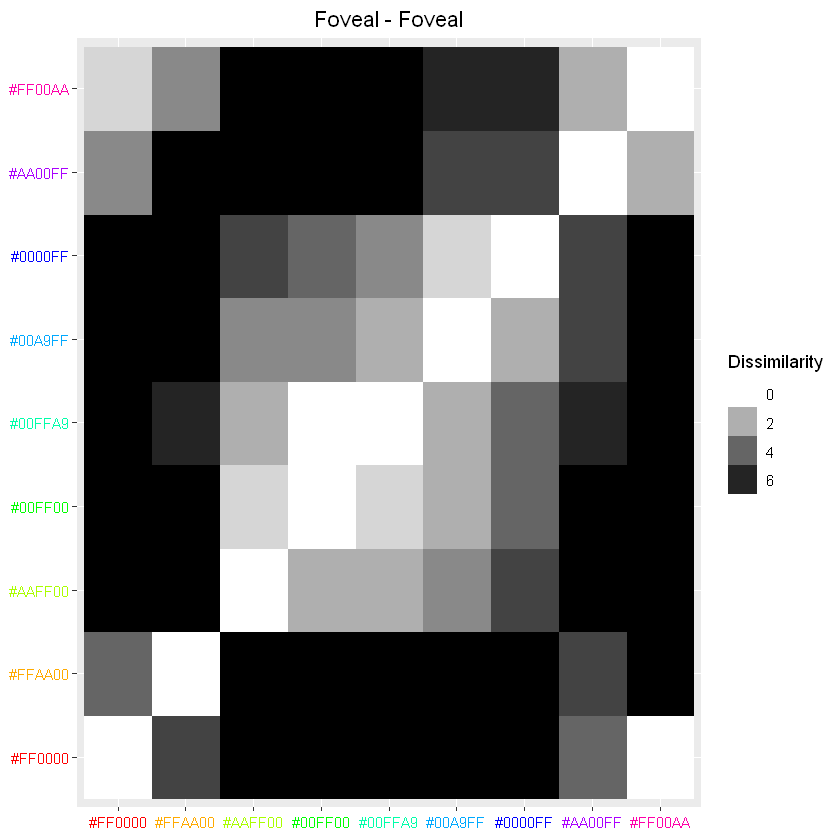

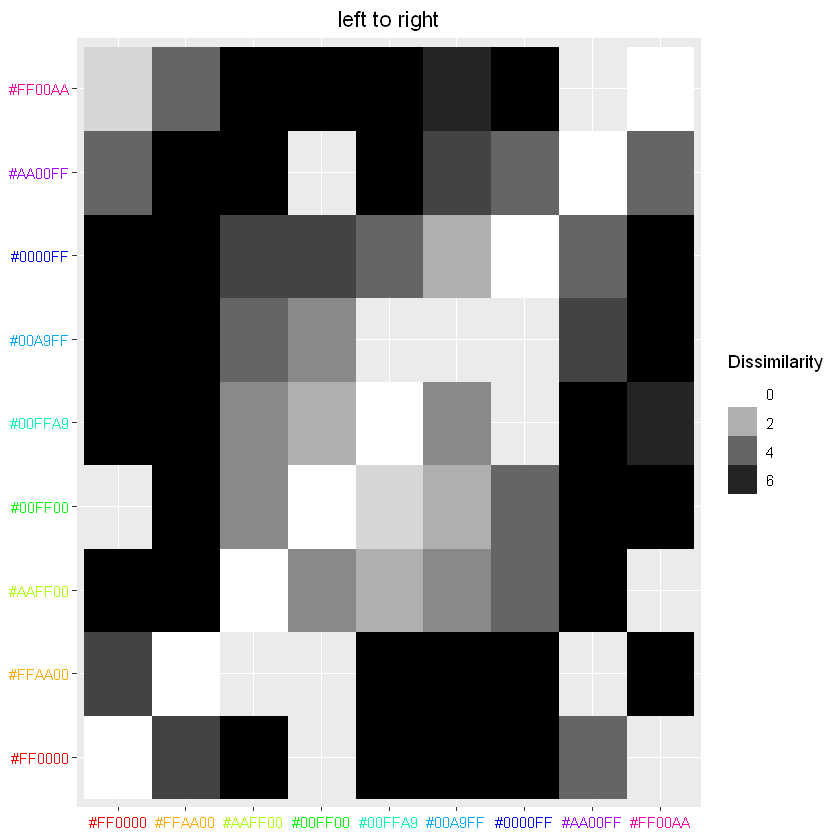

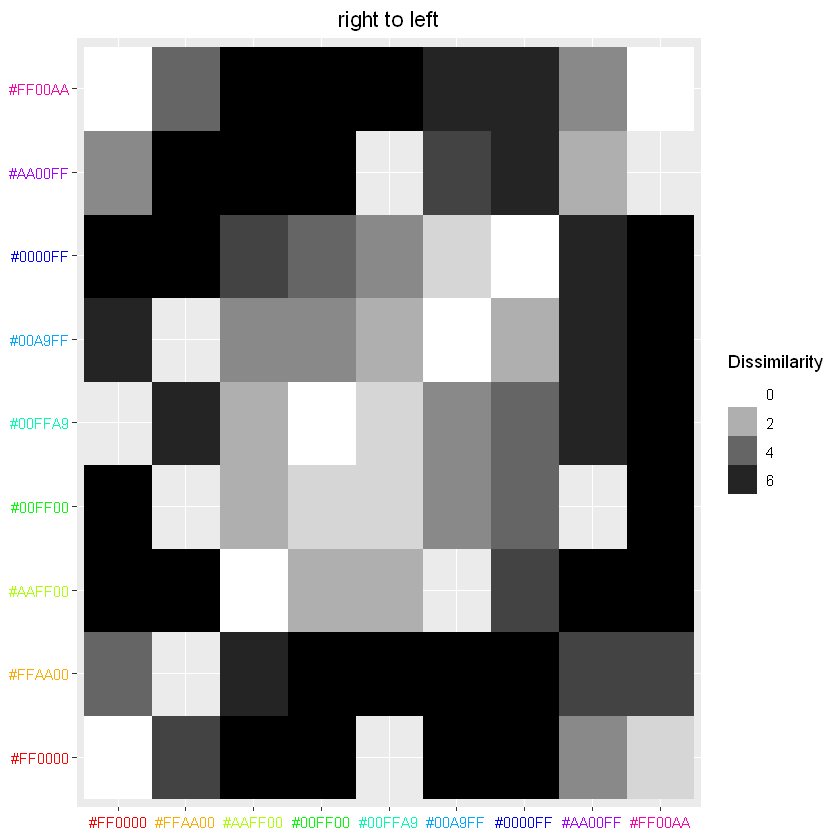

In [64]:
testdf <- subset(datadf, subject == 809668683)
testdf <- label_left_right(testdf)
testdf

dissimplot(dissimdata(testdf, colors, l2e('Foveal'), l2e('Foveal')),colors)
dissimplot_position(dissimdata_position_left2right(testdf, colors, Position_1, Position_2),colors)
#dissimplot_position(dissimdata_position_left2right(testdf, colors, Position_2, Position_1),colors)
dissimplot_position(dissimdata_position_right2left(testdf, colors, Position_1, Position_2),colors)

In [60]:
df2mat_asymmetry_position <- function(datadf,Position_1, Position_2){
    
    datadf <- dissimdata_position_left2right(datadf, colors, Position_1, Position_2)
    
    # aggregate over the remaining columns of interest
    nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    nmdsdata$Color_1 <- nmdsdata$Group.1
    nmdsdata$Color_2 <- nmdsdata$Group.2

    nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","p_confidence"))  # get rid of unnecessary columns
    nmdsmatrix <- spread(nmdsdata, Color_1, p_confidence)
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    matdf <- as.data.frame(nmdsmatrix - t(nmdsmatrix))
    matdf$colorset <- c(abcolors)
    num_colors <- length(colors)
    matdf <- matdf %>% gather(othercolor,asymmetry ,1:num_colors)
    return(matdf)
}

In [63]:
 nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
nmdsdata

Group.1,Group.2,experiment,stimuli_count,response_type,stim_display_time,stim_cue_gap,cue_display_time,subject,trial_number,...,Color_7,Circle_8,Position_8,Color_8,p_confidence,response_time,bin1,bin2,trial_type,noncompliant
#0000FF,#0000FF,NA,4,NA,250,NA,NA,478061534,120.1823,...,NA,NA,NA,NA,2.015625,1689.661,5.562500,8.690104,NA,1.742188
#00A9FF,#0000FF,NA,4,NA,250,NA,NA,478061534,127.4583,...,NA,NA,NA,NA,3.341146,1633.469,5.406250,8.554688,NA,1.742188
#00FF00,#0000FF,NA,4,NA,250,NA,NA,478061534,128.1667,...,NA,NA,NA,NA,4.283854,1533.948,5.447917,8.604167,NA,1.742188
#00FFA9,#0000FF,NA,4,NA,250,NA,NA,478061534,121.5990,...,NA,NA,NA,NA,4.184896,1184.008,5.484375,8.515625,NA,1.742188
#AA00FF,#0000FF,NA,4,NA,250,NA,NA,478061534,123.3646,...,NA,NA,NA,NA,3.859375,1474.221,5.500000,8.549479,NA,1.742188
#AAFF00,#0000FF,NA,4,NA,250,NA,NA,478061534,123.2630,...,NA,NA,NA,NA,4.466146,1229.284,5.593750,8.721354,NA,1.742188
#FF0000,#0000FF,NA,4,NA,250,NA,NA,478061534,126.0469,...,NA,NA,NA,NA,4.838542,1293.107,5.341146,8.536458,NA,1.742188
#FF00AA,#0000FF,NA,4,NA,250,NA,NA,478061534,123.3906,...,NA,NA,NA,NA,4.635417,1351.219,5.494792,8.513021,NA,1.742188
#FFAA00,#0000FF,NA,4,NA,250,NA,NA,478061534,121.1615,...,NA,NA,NA,NA,4.947917,1371.141,5.062500,8.252604,NA,1.742188
#0000FF,#00A9FF,NA,4,NA,250,NA,NA,478061534,116.2839,...,NA,NA,NA,NA,3.169271,1482.156,5.440104,8.598958,NA,1.742188


In [61]:
# plot an asymmetry matrix
asymmetry_plot_position <- function(datadf,Position_1, Position_2,colors){
    
    # labeling the types
    label1 <- "left"
    label2 <- "right"
    
    datadf <- df2mat_asymmetry_position(datadf, Position_1, Position_2)
    
    # refactor the levels so they can be plotted properly later if need be
    datadf$colorset <- with(datadf, factor(colorset, levels = colors))
    datadf$othercolor <- with(datadf, factor(othercolor, levels = colors))
    
    plot <- ggplot(datadf, aes(x = colorset, y = othercolor)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = asymmetry)) +
                labs(title = paste(label1, label2, sep = " to ")) +
                scale_fill_gradientn(colours = c("blue","white","red"), limits = c(-4,4)) +
                guides(fill=guide_legend(title="Dissimilarity\nAsymmetry"))
    return(plot)
}

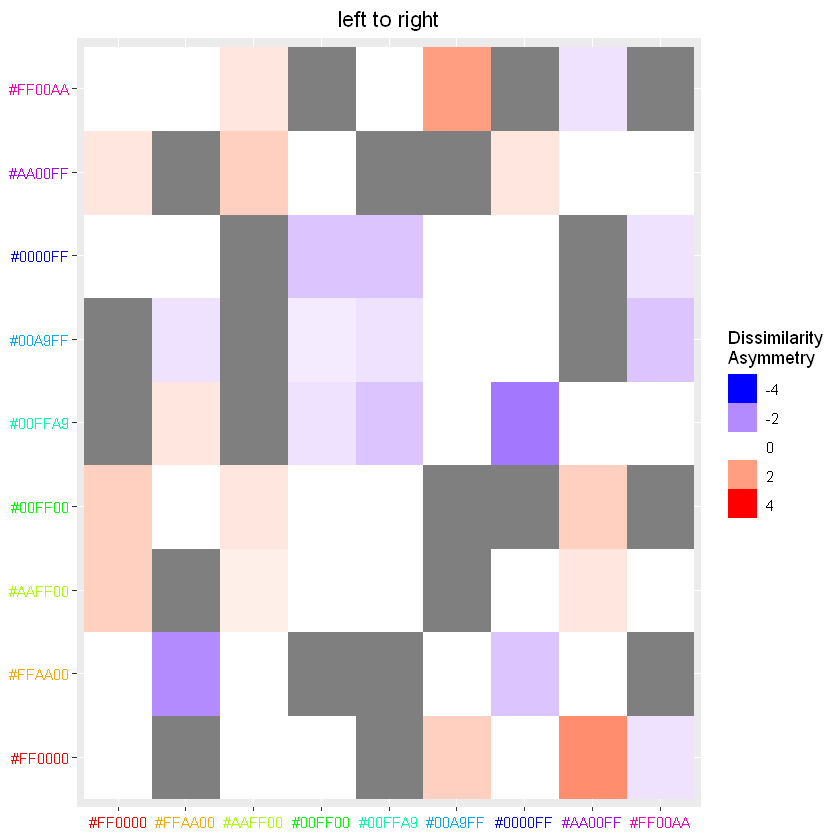

In [62]:
asymmetry_plot_position(testdf,Position_1, Position_2,colors)

Yusuke's code finish

Some actual data cleaning

In [51]:
# function to throw out  participants who didn't finish
remove_incomplete <- function(datadf,stimuli_number){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        if(as.character(datadf$response_type[1])=='after_1'){
            trialnumber = stimuli_number*stimuli_number*2 #F to response, P to response
        } else {
            trialnumber = stimuli_number*stimuli_number*3 #FF, FP, PP
        }
        if ( nrow(subset(datadf, subject == ID)) != trialnumber){ # see if they have the appropriate trial numbers
            print(paste("Subject",ID,"did not complete the task",sep=' '))
            datadf <- subset(datadf, subject != ID) # dump the subject
        }
    }
    return(datadf)
}

In [52]:
# actually throw out the subjects who didn't complete
datadf <- remove_incomplete(datadf,stimuli_number)

[1] "Subject 6012932 did not complete the task"
[1] "Subject 224000648 did not complete the task"
[1] "Subject 260546310 did not complete the task"
[1] "Subject 285547937 did not complete the task"
[1] "Subject 350715044 did not complete the task"
[1] "Subject 373747035 did not complete the task"
[1] "Subject 480971640 did not complete the task"
[1] "Subject 593249113 did not complete the task"
[1] "Subject 613876179 did not complete the task"
[1] "Subject 648596732 did not complete the task"
[1] "Subject 773122519 did not complete the task"
[1] "Subject 789422609 did not complete the task"
[1] "Subject 814700919 did not complete the task"
[1] "Subject 880753199 did not complete the task"
[1] "Subject 893284757 did not complete the task"
[1] "Subject 905952052 did not complete the task"
[1] "Subject 908241720 did not complete the task"
[1] "Subject 917271466 did not complete the task"
[1] "Subject 945283206 did not complete the task"


In [53]:
# function to label participants who meet statistical cleaning assumptions
label_noncompliant <- function(datadf,eccentricity,
                               trace_cutoff=2,antitrace_cutoff=4,rt_cutoff=1000){
    
    if(eccentricity == 'Foveal'){
        e_ind = 1
    } else if (eccentricity == 'Peripheral'){
        e_ind = 2
    }
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest 
        if(trace_avg(subjectdf)[e_ind] < trace_cutoff){
            if(antitrace_avg(subjectdf)[e_ind] > antitrace_cutoff){
                if(rt_avg(subjectdf) > rt_cutoff){
                    datadf$noncompliant[datadf$subject == ID] = 0
                } else {
                    print(paste("Subject",ID,"median reaction time of:",rt_avg(subjectdf),"ms",sep=' '))
                    datadf$noncompliant[datadf$subject == ID] = 1
                }
            } else {
                print(paste("Subject",ID,"had an antitrace of:",antitrace_avg(subjectdf)[e_ind],sep=' '))
                datadf$noncompliant[datadf$subject == ID] = 2
            }
        } else {
            print(paste("Subject",ID,"had a trace of:",trace_avg(subjectdf)[e_ind],sep=' '))
            datadf$noncompliant[datadf$subject == ID] = 3
        }
    }
    print(paste(length(unique(datadf$subject[datadf$noncompliant==0])),"of",length(unique(datadf$subject)),
                "were compliant",sep=' '))
    return(datadf)
}

In [54]:
datadf <- label_noncompliant(datadf,'Foveal')

[1] "Subject 2989630 had a trace of: 3.22666666666667"
[1] "Subject 3478854 had a trace of: 3.44444444444444"
[1] "Subject 13811877 had a trace of: 3.22222222222222"
[1] "Subject 36190138 had a trace of: 2.33333333333333"
[1] "Subject 37316066 had a trace of: 2.66777777777778"
[1] "Subject 42436095 had a trace of: 2.56111111111111"
[1] "Subject 51602224 had a trace of: 4.66666666666667"
[1] "Subject 56511823 had an antitrace of: 3.94444444444444"
[1] "Subject 69616059 had a trace of: 2.66888888888889"
[1] "Subject 69621683 had a trace of: 2.44444444444444"
[1] "Subject 84511979 had a trace of: 4.33555555555556"
[1] "Subject 93458386 had an antitrace of: 3.77777777777778"
[1] "Subject 100042706 had a trace of: 3.11333333333333"
[1] "Subject 102294477 had an antitrace of: 2.83444444444444"
[1] "Subject 103557621 median reaction time of: 750 ms"
[1] "Subject 114423889 had a trace of: 5.33333333333333"
[1] "Subject 129877772 had a trace of: 4.11111111111111"
[1] "Subject 137230626 median r

## Statistical Analysis

#### Determine within-subject central and peripheral QDM correlation & significance

In [ ]:
# return a list of the fovea matrix vs periphery matrix correlations for each subject

fvp_list <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
        correlation_list <- c(correlation_list, (matrixcor(subjectdf)))
    }
    return(correlation_list)
}

In [ ]:
# shuffle the rows of a matrix
shuffle_matrix <- function(matrix){
    shuffled <- matrix[sample(nrow(matrix)),]
    return(shuffled)
}

In [ ]:
# return a list of the fovea matrix vs. shuffled periphery matrix for each subject. Pick the # shuffles, default 1000.
# returns Fisher-transformed correlations

fvp_shuffled_list <- function(datadf, shuffle_num=1000){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
        
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
        
        temp_list <- vector()
        for (i in 1:shuffle_num){ #shuffle the peripheral matrix, add values to temp list
            pmatrix_shuffled <- shufflematrix(pmatrix)
            temp_list <- c(temp_list, FisherZ(cor(c(fmatrix), c(pmatrix_shuffled), method = "spearman")))
        }
        
        correlation_list <- c(correlation_list,mean(temp_list)) # add the average correlation to the list
        }
    return(correlation_list)
}

In [ ]:
# perform Mann-Whitney U test to compare the within-subject central and peripheral QDMs to randomly shuffled ones
within_subject_test <- function(original_correlations,shuffled_correlations){
    
    wilcox.test(original_correlations,shuffled_correlations)
}

In [ ]:
# do the analysis

#### Determine between-subject central to central QDM correlation & significance

In [ ]:
# obtain the subject similarity matrix
i_j_list <- function(datadf, eccentricity1=l2e('Foveal'), eccentricity2=l2e('Foveal')){
    
    datadf = subset(datadf, Circle_1 == eccentricity1)
    datadf = subset(datadf, Circle_2 == eccentricity2)
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID_i in subjectlist){ 
        for (ID_j in subjectlist){
            if(ID_i != ID_j){
                subjectdf_i = subset(datadf, subject == ID_i)
                subjectdf_j = subset(datadf, subject == ID_j)

                fmatrix_i <- df2mat(subjectdf_i, l2e('Foveal'), l2e('Foveal')) # get their fovea dissimilarity matrix
                fmatrix_j <- df2mat(subjectdf_j, l2e('Foveal'), l2e('Foveal')) # get their fovea dissimilarity matrix

                correlation_list <- c(correlation_list, cor(c(fmatrix_i), c(fmatrix_j), method = "spearman"))
                }
        }
    }
    return(correlation_list)
}

In [ ]:
# obtain a shuffled subject similarity matrix

In [ ]:
# test where the correlation of the original SSM sits in comparison to the shuffled SSMs

In [ ]:
# do the analysis

#### Determine whether within-subject central-peripheral QDM correlation is equal to or greater than between-subject central-central QDMs

In [ ]:
# blah

In [ ]:
# do the analysis

In [ ]:
# correlation plot
corr_plot <- function(correlation_list,title='BLANK',xlabel='BLANK',f2z=FALSE){
    df <- data.frame(correlation_list) # convert list to data frame
    df[xlabel] = xlabel
    
    plot <- ggplot(df,aes(x=xlabel,y=correlation_list)) + 
                geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                theme(text = element_text(size=15)) + xlab("")
                ggtitle(title)
    if(f2z){
                plot <- plot + ylab("Fisher-Transformed Correlation (Spearman)") + ylim(-1,2)
    } else {
                plot <- plot + ylab("Correlation (Spearman)") + ylim(-0.5,1)

    }
    plot <- plot + geom_hline(yintercept=0, linetype="dashed", color = "blue")
    return(plot)
}

In [ ]:
within_between_plots <- function(datadf,savestr){
    
    fvp <- fvp_list(datadf)
    i_j <- i_j_list(datadf)
    
    within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
    between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
    within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
    between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

    # save the plots
    title <- textGrob(substr(savestr,nchar('data/')+1,nchar(savestr)))
    g <- arrangeGrob(within_plot,between_plot,
                     within_plot_fisher,between_plot_fisher,
                        nrow = 2, ncol= 2,
                    top = title)

        # save it
    ggsave(paste(savestr,"_Subject_Plots/","correlation plot comparisons_","plot.png",sep=''),g, height = 11, width = 10)
}

In [ ]:
# plot within-subject FvP correlations against between-subject FvF correlations
if(plot_within_between){within_between_plots(datadf,savestr)}

Additional experimental summary graphs

In [ ]:
# obtains a dataframe of traces for subjects
trace_obtainer <- function(datadf,type="trace"){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    tracedf <- data.frame(subject=character(),ftrace=double(),ptrace=double()) # initialise an output df for the traces
    for (ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        if(type == 'antitrace'){
            subject_trace <- antitrace_avg(tempdf)
        } else if (type == 'difference'){
            subject_trace <- unlist(antitrace_avg(tempdf),use.names=FALSE) - unlist(trace_avg(tempdf),use.names=FALSE)
        }else{
            subject_trace <- trace_avg(tempdf)
        }
        row_df <- data.frame(ID, as.numeric(subject_trace[1]),as.numeric(subject_trace[2]))
        names(row_df) <- c("subject","Fovea x Fovea","Periphery x Periphery")
        tracedf<- rbind(tracedf,row_df)
    }
    return(tracedf)
}

In [ ]:
# plot the traces for the subjects individually
trace_plot <- function(datadf,type='trace',grouped=TRUE){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    if(type == 'antitrace'){
        trace_df <- trace_obtainer(datadf,'antitrace')
    } else if (type == 'difference'){
        trace_df <- trace_obtainer(datadf,'difference')
    } else {
        trace_df <- trace_obtainer(datadf)
    }
    
    
    tracedf <- gather(trace_df, key = "eccentricity",value = "trace", 2:3)
    
    if(grouped){
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace)) +
        geom_boxplot() + geom_dotplot(binaxis='y',stackdir='center',dotsize=0.5) +
        theme(legend.position = "none")
    } else {
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace, group = subject, color = subject)) +
        geom_line() + theme(legend.position = "none")
    }
    
    if(type == 'antitrace'){
        plot <- plot + ylim(0,7) + ylab("Mean Physically Maximally Distinct Stimulus Similarity")
    } else if (type == 'difference'){
        plot <- plot + ylim(-6,6) + ylab("Distinct - Identical")
    } else {
        plot <- plot + ylim(0,7) + ylab("Mean Physically Identical Stimulus Similarity")
    }
    
    return(plot)
}

### Plot summary of all subjects

#### Individual subjects

In [ ]:
# plot summary data for all the subjects individually
allsubjectsplot <- function(datadf,savestr){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects

    dir.create(paste(savestr,"Subject_Plots",sep='_')) # make a new folder to store the subject plots in

    for (subjectid in subjectlist){
        print(paste("Processing subject:",subjectid,sep=' '))
        subjectplot(datadf, subjectid,savestr)
    }
}

In [ ]:
# make a plot of the key summary data for a subject
subjectplot <- function(datadf, subjectid,savestr){
    
    subjectdf = subset(datadf, subject == subjectid) # select the ID for subject of interest
    
    if(subjectdf$response_type[1] != 'after_1'){
        FP = TRUE
    } else {
        FP = FALSE
    }
    
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Foveal'), l2e('Foveal')),colors)
    
    
    
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Peripheral'), l2e('Peripheral')),colors)
    
    # FF CMDS plot
    FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
    
    
    
    # PP CMDS plot
    PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    
    # FF nMDS plot
    FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
    
    
    
    # PP nMDS plot
    PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    
    # Similarity judgements
    simplot <- simhistplot(subjectdf)
    # Reaction times
    reactionplot <- rsplot(subjectdf)
    # summary plot
    rainplot <- rsplot_raincloud(subjectdf,'log')
    
    # trace plots
    traceplot <- trace_plot(subjectdf)
    antiplot <- trace_plot(subjectdf,'antitrace')
    differenceplot <- trace_plot(subjectdf,'difference')
    
    # asymmetry plot
    asymplot <- asymmetry_plot(subjectdf,l2e('Foveal'),l2e('Foveal'),colors)
    
    # title
    if(subjectdf$noncompliant[1]){
        title <- textGrob(as.character(subjectid),gp=gpar(col="red",fontsize=35))
    } else {
        title <- textGrob(as.character(subjectid),gp=gpar(col="blue",fontsize=35))
    }
    
    if(FP){
        
        # FP Matrix plot
        FPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Foveal'), l2e('Peripheral')),colors)
        
        # FP CMDS plot
        FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))
        
        # FP nMDS plot
        FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))
        
        # put all the plots together
        g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, simplot,
                    FFcmds, FPcmds, PPcmds, reactionplot,
                    FFnmds, FPnmds, PPnmds, rainplot,
                    traceplot, antiplot, differenceplot, asymplot,
                    nrow = 4, ncol=4, top = title)
        
        stimuli <- as.character(subjectdf$stimuli_count[1])
        exp_type <- as.character(subjectdf$response_type[1])
        ggsave(paste(savestr,"_Subject_Plots/",stimuli,"_stimuli_",exp_type,"_ID_",subjectid,"_plot.png",
                 sep=''),g, height = 40, width = 40)
    } else {
        # put all the plots together
        g <- arrangeGrob(FFmatrix, PPmatrix, simplot, traceplot,
                    FFcmds, PPcmds, reactionplot, antiplot,
                    FFnmds, PPnmds, rainplot, asymplot,
                    nrow = 3, ncol=4, top = title)
        
        stimuli <- as.character(subjectdf$stimuli_count[1])
        exp_type <- as.character(subjectdf$response_type[1])
        ggsave(paste(savestr,"_Subject_Plots/",stimuli,"_stimuli_",exp_type,"_ID_",subjectid,"_plot.png",
                 sep=''),g, height = 30, width = 40)
    }
}

In [ ]:
if(plotsubjects){
    allsubjectsplot(datadf,savestr)
}

### Summary plots

In [ ]:
dir.create(paste(savestr,"Summary_Plots",sep='_'))

In [ ]:
# matrix to use to define the plot layout, specified manually for now
hlay <- rbind (c(1,4,7,10),
               c(2,5,8,11),
               c(3,6,9,12))

In [ ]:
# correlations summary plot
across_experiment_plot <- function(datadf,savestr,laymatrix,response_type_list,response_names,dependent,clean=FALSE){
    
    dir.create(paste(savestr,"Overall_Summary_Plots",sep='_'))
    
    stimuli_list <- sort(unique(datadf$stimuli_count))
    plot_list <- list()
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    # make all the plots
    k = 0
    for (stimulus in stimuli_list){
        for (response in response_type_list){
            k = k + 1
            if(stimulus == 2){ # 2 stimuli doesn't have any cueing, so it gets an exception
                tempdf <- subset(datadf, stimuli_count == 2)
            } else {
                tempdf <- subset(datadf, stimuli_count == stimulus & response_type == response)
            }
            
            # make the specific plot
            if(dependent=='correlation'){
                fvp <- fvp_list(tempdf)
                plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
                title <- textGrob("CORRELATION", gp=gpar(fontsize=35))
            } else if (dependent=='RT'){
                plot <- rsplot_summary(tempdf)
                title <- textGrob("REACTION TIME", gp=gpar(fontsize=35))
            } else if (dependent=='dissimilarity'){
                plot <- simhistplot_summary(tempdf)
                title <- textGrob("DISSIMILARITY", gp=gpar(fontsize=35))
            } else if (dependent=='trace'){
                plot <- trace_plot(tempdf)
                title <- textGrob("TRACE", gp=gpar(fontsize=35))
            } else if (dependent=='antitrace'){
                plot <- trace_plot(tempdf,'antitrace')
                title <- textGrob("ANTITRACE", gp=gpar(fontsize=35))
            } else if (dependent=='difference'){
                plot <- trace_plot(tempdf,'difference')
                title <- textGrob("ANTITRACE - TRACE", gp=gpar(fontsize=35))
            } else if (dependent=='asymmetry_matrix'){
                plot <- asymmetry_plot(tempdf,l2e('Foveal'),l2e('Foveal'),colors)
                title <- textGrob("SIMILARITY ASYMMETRY MATRIX", gp=gpar(fontsize=35))
            } else if (dependent == 'trace_by_trial'){
                plot <- trace_by_trial_plot(tempdf,'boxplot')
                title <- textGrob("Trace by Trial", gp=gpar(fontsize=35))
            }
            
            
            plot <- plot + xlab(paste(stimulus,response,sep=' ')) #  add a label
            if(stimulus == 2 && k != 1){ # don't plot after-cueing for 2 cue stimuli
                plot <- ggplot() + geom_blank() + theme_void()
            } else if (dependent == 'asymmetry_matrix' && response != 'after_1'){
                plot <- ggplot() + geom_blank() + theme_void()
            }
            plot_list[[k]] <- as.grob(plot) # add it to the plot_list
        }
        
    }
    
    # save the plots
    yaxis <- textGrob("Cueing Type", gp=gpar(fontsize=30), rot=90)
    xaxis <- textGrob("Stimuli", gp=gpar(fontsize=30))
    
    g <- arrangeGrob(grobs = plot_list, ncol = length(stimuli_list),nrow = length(response_type_list),
                     layout_matrix = hlay)
    
    g_rowcol_names <- rbind(tableGrob(t(stimuli_list), theme = ttheme_minimal(), rows = ""),
                cbind(tableGrob(response_names, theme = ttheme_minimal()),
                      g, size = "last"), size = "last")
    
    g_titled <- arrangeGrob(g_rowcol_names, top = title, left = yaxis, bottom = xaxis)
    
    if(clean){
        savename <- paste(savestr,"_Overall_Summary_Plots/",dependent,"_CLEAN","_plot.png",sep='')
        ggsave(savename,g_titled, height = 20, width = 30)
    }else{
        savename <- paste(savestr,"_Overall_Summary_Plots/",dependent,"_plot.png",sep='')
        ggsave(savename,g_titled, height = 20, width = 30)
    }
    
    return(g_titled)
}

In [ ]:
across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace_by_trial')
across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace_by_trial',TRUE)

#### Across all experiments

In [ ]:
across_all <- function(datadf,savestr,laymatrix,response_type_list,response_names){
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'RT')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'dissimilarity')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'asymmetry_matrix')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'correlation')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'antitrace')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'difference')
    
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'RT',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'dissimilarity',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'asymmetry_matrix',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'correlation',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'antitrace',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'difference',TRUE)
}

In [ ]:
if(across){
    across_all(datadf,savestr,hlay,response_type_list,response_names)
}

#### Individual experiment summaries

In [ ]:
# generate a summary plot of all the collected data from all the subjects in the experiment
# NEED TO FINISH THIS
expsummaryplot <- function(datadf,savestr,clean=FALSE){
    
    dir.create(paste(savestr,"Exp_Summary_Plots/",sep='_'))
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    stimuli_list <- sort(unique(datadf$stimuli_count))
    
    # make all the plots
    k = 0
    for (stimulus in stimuli_list){
        for (response in response_type_list){
            
            k = k + 1
            if(stimulus == 2){ # 2 stimuli doesn't have any cueing, so it gets an exception
                tempdf <- subset(datadf, stimuli_count == 2)
            } else {
                tempdf <- subset(datadf, stimuli_count == stimulus & response_type == response)
            }
            
            if(response != 'after_1'){
                FP = TRUE
            } else {
                FP = FALSE
            }
            
            # make the specific summary plot
           
            # MATRICES
            everyonedata <- aggregate_df(tempdf)
            
            stim_time <- everyonedata$stim_display_time[1]
            gap <- everyonedata$stim_cue_gap[1]
            cue_time <- everyonedata$cue_display_time[1]
            
            
            # FF Matrix plot
            FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

            # FP Matrix plot
            FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors)

            # PP Matrix plot
            PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

            # CMDS
            # FF CMDS plot
            FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

            FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # FF CMDS plot
            PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
            # NMDS
            # FF nMDS plot
            FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

            # FP nMDS plot
            FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # PP nMDS plot
            PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

            # AUXILIARY plots
            # Similarity judgements
            simplot <- simhistplot_summary(tempdf)
            # Reaction times v1
            reactionplot <- rsplot_summary(tempdf)
            # summary plot
            raincloudplot <- rsplot_raincloud(tempdf,'log')

            # within_between_plots
            fvp <- fvp_list(tempdf)
            i_j <- i_j_list(tempdf)

            within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
            between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
            #within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
            #between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

            # MORE PLOTS
            # trace plots
            traceplot <- trace_plot(tempdf)
            antiplot <- trace_plot(tempdf,'antitrace')
            differenceplot <- trace_plot(tempdf,'difference')
            
            N <- length(unique(tempdf$subject)) # get number of subjects
            
            # save the plots
            if(clean){
                title <- textGrob(paste(stimulus,response,
                                    "stim_duration",stim_time,"gap",gap,"cue_duration",cue_time,
                                    N,"subjects","CLEAN",
                                    sep="_"), gp=gpar(fontsize=35))
            }else{
                title <- textGrob(paste(stimulus,response,
                                    "stim_duration",stim_time,"gap",gap,"cue_duration",cue_time,
                                    N,"subjects",
                                    sep="_"), gp=gpar(fontsize=35))
            }
            
            # put it all together
            if(FP){
                
                g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, within_plot, between_plot,
                                FFcmds,FPcmds, PPcmds, traceplot, antiplot,
                                FFnmds,FPnmds, PPnmds, raincloudplot, differenceplot,
                                simplot, reactionplot, 
                                nrow = 4, ncol=5, top = title)
            } else {
                
                # asymmetry plot
                asymplot <- asymmetry_plot(tempdf,l2e('Foveal'),l2e('Foveal'),colors)
                
                g <- arrangeGrob(FFmatrix,  PPmatrix, within_plot, between_plot, 
                                FFcmds, PPcmds, traceplot,  antiplot,
                                FFnmds, PPnmds, differenceplot, asymplot,
                                simplot, raincloudplot, reactionplot,
                                nrow = 4, ncol=4, top = title)

                
            }
                # save it
            if(clean){
                savename <- paste(savestr,"_Exp_Summary_Plots/",stimulus,"_",response,
                         "_Summary_",N,"_subjects","_CLEAN","_plot.png",sep='')
            }else {
                savename <- paste(savestr,"_Exp_Summary_Plots/",stimulus,"_",response,
                         "_Summary_",N,"_subjects","_plot.png",sep='')
            }
                
                print(savename)
                ggsave(savename,g, height = 38, width = 48)
        }
            
    }
        
}   

### Across the entire population 

In [ ]:
# entire population plot
population_plot <- function(datadf,savestr,clean=FALSE){
    
    dir.create(paste(savestr,"Population_Summary_Plots/",sep='_'))
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    # MATRICES
    everyonedata <- aggregate_df(datadf)

    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors)

    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

    # CMDS
    # FF CMDS plot
    FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

    FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

    # FF CMDS plot
    PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    # NMDS
    # FF nMDS plot
    FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

    # FP nMDS plot
    FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

    # PP nMDS plot
    PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

    # AUXILIARY plots
    # Similarity judgements
    simplot <- simhistplot_summary(datadf)
    # Reaction times v1
    reactionplot <- rsplot_summary(datadf)
    # summary plot
    raincloudplot <- rsplot_raincloud(datadf,'log')

    # within_between_plots
    fvp <- fvp_list(datadf)
    i_j <- i_j_list(datadf)

    within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
    between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
    #within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
    #between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

    # MORE PLOTS
    # trace plots
    traceplot <- trace_plot(datadf)
    antiplot <- trace_plot(datadf,'antitrace')
    differenceplot <- trace_plot(datadf,'difference')

    N <- length(unique(datadf$subject)) # get number of subjects

    # save the plots
    if(clean){
        title <- textGrob(paste("Population",
                            N,"subjects","CLEAN",
                            sep="_"), gp=gpar(fontsize=35))
    }else{
        title <- textGrob(paste("Population",
                            N,"subjects",
                            sep="_"), gp=gpar(fontsize=35))
    }
    
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, within_plot, between_plot,
                                FFcmds,FPcmds, PPcmds, traceplot, antiplot,
                                FFnmds,FPnmds, PPnmds, raincloudplot, differenceplot,
                                simplot, reactionplot, 
                                nrow = 4, ncol=5, top = title)
    
     # save it
    if(clean){
        savename <- paste(savestr,"_Exp_Summary_Plots/",
                 "_Summary_",N,"_subjects","_CLEAN","_plot.png",sep='')
    }else {
        savename <- paste(savestr,"_Exp_Summary_Plots/",
                 "_Summary_",N,"_subjects","_plot.png",sep='')
    }

        print(savename)
        ggsave(savename,g, height = 38, width = 48)
}

In [ ]:
if(plotexpsummary){
    expsummaryplot(datadf,savestr)
    expsummaryplot(datadf,savestr,TRUE)
}

In [ ]:
if(population){
    population_plot(datadf,savestr)
    population_plot(datadf,savestr,TRUE)
}

In [ ]:
# position plot (negative control)
positionplot <- function(datadf){
    # MATRICES
    everyonedata <- aggregate_df(datadf)
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors, 'position')
    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors, 'position')
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors, 'position')
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix,
                    nrow = 1, ncol= 3)
     # save it
    ggsave(paste(savestr,"position negative control","plot.png",sep='_'),g, height = 10, width = 30)
}

In [ ]:
testdf <- subset(datadf, subject == 809668683)
testdf

In [ ]:
datadf$Position_1